# Frogs to be

This dataset comes from the lab of Professor David Prober, he studied the behaviour of zebrafish larvae (frogs to be). He recorded their movments with a camera. Some of these fish have a mutation, other do not. How does this mutation affect wakefullness? 
The metrics that will be used are: 
-  active bout: a period of time where a fish is costantly active
-  active bout lenght: number of consecutive minutes with activity 

### Data exploration

The first step in the analysis is to take a look at the data and confront the distribution of the populations of larvae with the mutation and those without

In [6]:
import numpy as np 
from numpy import genfromtxt
bout_lengths_wt = genfromtxt('/Users/jackfederle/Documents/python/Data/bout_lengths_wt.csv')
bout_lengths_mut = genfromtxt('/Users/jackfederle/Documents/python/Data/bout_lengths_mut.csv')
bout_lengths_het = genfromtxt('/Users/jackfederle/Documents/python/Data/bout_lengths_het.csv')

In [7]:
# down the line I saw that code was not running because of some nan
bout_lengths_het = bout_lengths_het[np.logical_not(np.isnan(bout_lengths_het))]
print(np.mean(bout_lengths_het))

4.430888315517877


In [8]:
import numpy as np
def ecdf(data):
    
    # compute x and y to the plot them 
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y

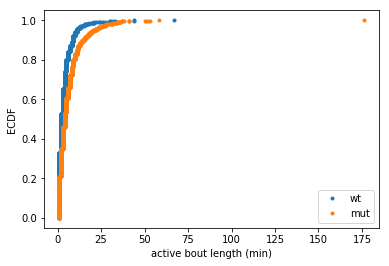

In [9]:
import matplotlib.pyplot as plt

x_wt, y_wt = ecdf(bout_lengths_wt)
x_mut, y_mut = ecdf(bout_lengths_mut)

_ = plt.plot(x_wt, y_wt, marker='.', linestyle='none')
_ = plt.plot(x_mut, y_mut, marker='.', linestyle='none')

_ = plt.legend(('wt', 'mut'))
_ = plt.xlabel('active bout length (min)')
_ = plt.ylabel('ECDF')
plt.show()

Looks like an exponential distribution, becoming inactive happens randomly for these fish.
Next I'm going to look at the mean of the active bout for both populations, I will use bootstrap to get an idea of the accuracy. I'm not going to deal with that outlier here.

In [10]:
def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):

    bs_replicates = np.empty(size)

    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [11]:
mean_wt = np.mean(bout_lengths_wt)
mean_mut = np.mean(bout_lengths_mut)

bs_reps_wt = draw_bs_reps(bout_lengths_wt, np.mean, size=10000)
bs_reps_mut = draw_bs_reps(bout_lengths_mut, np.mean, size=10000)

conf_int_wt = np.percentile(bs_reps_wt, [2.5, 97.5])
conf_int_mut = np.percentile(bs_reps_mut, [2.5, 97.5])

print("""
wt:  mean = {0:.3f} min., confidence intervals = [{1:.1f}, {2:.1f}] min.
mut: mean = {3:.3f} min., confidence intervals = [{4:.1f}, {5:.1f}] min.
""".format(mean_wt, *conf_int_wt, mean_mut, *conf_int_mut))


wt:  mean = 3.874 min., confidence intervals = [3.6, 4.1] min.
mut: mean = 6.543 min., confidence intervals = [6.1, 7.0] min.



It looks like the mutation has an effect on the lengeth of the bout, even though the intervals are fairly wide.

In [12]:
#TODO plt.errorbar

### Next I'm going to explore the difference between the heterozigotic and wild type fish. 

The heterozigotic fish have inhibited melatonine production, I am pretty sure that this has an effect on their bouts. 
I will test the hypotesis that there is no difference between the two populations.
I will use permutation to test that. 

In [18]:
def diff_of_means(data1, data2): 
    diff = np.mean(data1) - np.mean(data2)
    return diff

In [19]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [20]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # array to store the replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # compute the test statistic on the generated samples
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [16]:
diff_means = np.mean(bout_lengths_het) - np.mean(bout_lengths_wt)

perm_reps = draw_perm_reps(bout_lengths_het, bout_lengths_wt, diff_of_means, size=10000)

p_val = np.sum(perm_reps >= diff_means) / len(perm_reps)

print('p =', p_val)

p = 0.0014


The chance to get the observed data if the frogs were exactly the same is 0.1% 

Now I will test the hypothesis that the means are truely equal:

In [17]:
# Concatenate arrays: bout_lengths_concat
bout_lengths_concat = np.concatenate((bout_lengths_wt, bout_lengths_het))

# Compute mean of all bout_lengths: mean_bout_length
mean_bout_length = np.mean(bout_lengths_concat)

# Generate shifted arrays
wt_shifted = bout_lengths_wt - np.mean(bout_lengths_wt) + mean_bout_length
het_shifted = bout_lengths_het - np.mean(bout_lengths_het) + mean_bout_length

# Compute 10,000 bootstrap replicates from shifted arrays
bs_reps_wt = draw_bs_reps(wt_shifted, np.mean,size=10000)
bs_reps_het = draw_bs_reps(het_shifted, np.mean,size=10000)

# Get replicates of difference of means: bs_replicates
bs_reps =  bs_reps_het - bs_reps_wt

# Compute and print p-value: p
p = np.sum(bs_reps >= diff_means) / len(bs_reps)
print('p-value =', p)

p-value = 0.0007


I got a result of similar magnitude as the permutation test, though slightly smaller. I can safely state that the two populations are not identical.